In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import stats
import math
pd.options.display.max_rows=200
import seaborn as sns

In [2]:
df_id_result = pd.read_csv('/data/210827_SJH_prosit/211025STRIP_PEP/massIVE-KB_result.tsv', sep='\t')
df_nid_result = pd.read_csv('/data/210827_SJH_prosit/211025STRIP_PEP/uniprot_result.tsv', sep='\t')

In [3]:
print(df_id_result.shape)
df_id_result.head(1)

(764191, 17)


,#SpecFile,SpecID,ScanNum,Title,FragMethod,Precursor,IsotopeError,PrecursorError(ppm),Charge,Peptide,Protein,DeNovoScore,MSGFScore,SpecEValue,EValue,QValue,PepQValue
0,massIVE-KB_predMS2_frac01.mgf,index=48780,-1,"48781 File:""massIVE-KB_predMS2_frac48781.mgf"",...",HCD,1148.5422,0,0.0,3,ILGWGVENGTPYWLVANSWNTDWGDNGFFK,"sp|P07858|CATB_HUMAN(pre=R,post=I);tr|R4GMQ5|R...",218,213,3.842356e-39,1.063139e-31,0.0,0.0


In [4]:
print(df_nid_result.shape)
df_nid_result.head(1)

(1425608, 17)


,#SpecFile,SpecID,ScanNum,Title,FragMethod,Precursor,IsotopeError,PrecursorError(ppm),Charge,Peptide,Protein,DeNovoScore,MSGFScore,SpecEValue,EValue,QValue,PepQValue
0,uniprot_predMS2_frac01.mgf,index=17130,-1,"17131 File:""uniprot_predMS2_frac17131.mgf"", Na...",HCD,1941.3418,0,0.0,2,SWEEYFEWFC+57.021QGTVLYGSWFDHIHGWMPMR,"sp|Q06520|ST2A1_HUMAN(pre=K,post=E)",258,258,5.214888e-43,1.442904e-35,0.0,0.0


In [6]:
df_id_result['Peptide'] = df_id_result.Peptide.apply(lambda x: x.replace('C+57.021', 'C'))
df_nid_result['Peptide'] = df_nid_result.Peptide.apply(lambda x: x.replace('C+57.021', 'C'))

* FDR control

In [7]:
def isDecoy(prot):
    prot_cnt = len(prot.split(';'))
    decoy_cnt = 0
    for p in prot.split(';'):
        if 'XXX' in p:
            decoy_cnt += 1
    if decoy_cnt == prot_cnt:
        return 'D'
    else:
        return 'T'

def getFDR(TD_list):
    start = time.time()
    
    FDR_list = []
    T_cnt = 0
    D_cnt = 0
    cut_idx = 0
    
    for idx, label in enumerate(TD_list):
        if label=='T':
            T_cnt += 1
        elif label == 'D':
            D_cnt += 1
        fdr = round((2*D_cnt) / (T_cnt + D_cnt), 2)
        if fdr <= 0.01:
            cut_idx = idx
    return cut_idx

def FDR_control(df, PERCENT):
    df_ = df.sort_values('SpecEValue').reset_index(drop=True)  # copy
    df_['TD_label'] = df_.Protein.apply(isDecoy).values
    print('********** Target Decoy Labelling Done **********')
    cut_idx = getFDR(df_.TD_label.values)  
    print('********** Calculating FDR Done **********')
    df_ = df_.iloc[:cut_idx+1].reset_index(drop=True)
    df_ = df_.loc[df_.TD_label=='T'].reset_index(drop=True)
    return df_

In [10]:
df_id_target = FDR_control(df_id_result, 0.01)

********** Target Decoy Labelling Done **********
********** Calculating FDR Done **********


In [11]:
df_nid_target = FDR_control(df_nid_result, 0.01)

********** Target Decoy Labelling Done **********
********** Calculating FDR Done **********


In [12]:
max(df_id_target.EValue.values), min(df_id_target.EValue.values)  # maaIVE-KB

(127.47247, 1.5074339925461614e-33)

In [13]:
max(df_nid_target.EValue.values), min(df_nid_target.EValue.values)  # uniprot

(205.59102, 1.442904175876456e-35)

* decoy protien identificatin count

In [14]:
from matplotlib_venn import venn2, venn2_circles

nonDetection Peptide set : 2579
intersection cnt : 17
Detection Peptide set : 134
whole cnt : 2696



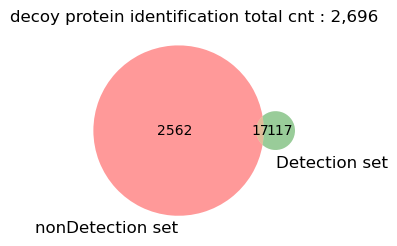

In [15]:
nid_proteins = {__.split('(')[0] for _ in df_nid_target.Protein.values for __ in _.split(';') if 'XXX' in __}
id_proteins = {__.split('(')[0] for _ in df_id_target.Protein.values for __ in _.split(';') if 'XXX' in __}

print('nonDetection Peptide set : {}\n\
intersection cnt : {}\n\
Detection Peptide set : {}\n\
whole cnt : {}\n'.format(len(nid_proteins),
         len(nid_proteins.intersection(id_proteins)),
         len(id_proteins),
         len(nid_proteins.union(id_proteins))))

plt.figure(figsize=(3, 3))
v = venn2(subsets=[nid_proteins, id_proteins], set_labels=('nonDetection set', 'Detection set'))
plt.title('decoy protein identification total cnt : {:,}'.format(len(nid_proteins.union(id_proteins))))
plt.show()

In [16]:
df_id_target_removeDecoy = df_id_target.copy()
df_nid_target_removeDecoy = df_nid_target.copy()

p = []
for prot in df_id_target_removeDecoy.Protein.values:
    p.append(';'.join([_ for _ in prot.split(';') if 'XXX' not in _]))
df_id_target_removeDecoy['Protein'] = p
df_id_target_removeDecoy = df_id_target_removeDecoy.loc[df_id_target_removeDecoy.Protein!='']
p = []
for prot in df_nid_target_removeDecoy.Protein.values:
    p.append(';'.join([_ for _ in prot.split(';') if 'XXX' not in _]))
df_nid_target_removeDecoy['Protein'] = p
df_nid_target_removeDecoy = df_nid_target_removeDecoy.loc[df_nid_target_removeDecoy.Protein!='']

In [17]:
unique_idx = np.where(df_id_target_removeDecoy.Protein.apply(lambda x: ';' not in x))[0]
shared_idx = np.where(df_id_target_removeDecoy.Protein.apply(lambda x: ';' in x))[0]
unique_cnt = len(df_id_target_removeDecoy.loc[unique_idx].Peptide.unique())
shared_cnt = len(df_id_target_removeDecoy.loc[shared_idx].Peptide.unique())
protein_nonMutate = {__.split('(')[0] for _ in df_id_target_removeDecoy.Protein.values for __ in _.split(';')}

print("총 PSM 수 :", len(df_id_target_removeDecoy))
print("펩타이드 수 :", len(df_id_target_removeDecoy.Peptide.unique()))
print('Unique 펩타이드 수 :', unique_cnt)
print('Shared 펩타이드 수 :', shared_cnt)
print('단백질 수 :', len(protein_nonMutate))

unique_idx = np.where(df_nid_target_removeDecoy.Protein.apply(lambda x: ';' not in x))[0]
shared_idx = np.where(df_nid_target_removeDecoy.Protein.apply(lambda x: ';' in x))[0]
unique_cnt = len(df_nid_target_removeDecoy.loc[unique_idx].Peptide.unique())
shared_cnt = len(df_nid_target_removeDecoy.loc[shared_idx].Peptide.unique())
protein_nonMutate = {__.split('(')[0] for _ in df_nid_target_removeDecoy.Protein.values for __ in _.split(';')}

print("총 PSM 수 :", len(df_nid_target_removeDecoy))
print("펩타이드 수 :", len(df_nid_target_removeDecoy.Peptide.unique()))
print('Unique 펩타이드 수 :', unique_cnt)
print('Shared 펩타이드 수 :', shared_cnt)
print('단백질 수 :', len(protein_nonMutate))

총 PSM 수 : 762999
펩타이드 수 : 455968
Unique 펩타이드 수 : 204222
Shared 펩타이드 수 : 251746
단백질 수 : 63986
총 PSM 수 : 1422276
펩타이드 수 : 1416189
Unique 펩타이드 수 : 676862
Shared 펩타이드 수 : 739327
단백질 수 : 67120


* Protein identification count

In [18]:
nid_proteins = {__.split('(')[0] for _ in df_nid_target.Protein.values for __ in _.split(';') if 'XXX' not in __}
id_proteins = {__.split('(')[0] for _ in df_id_target.Protein.values for __ in _.split(';') if 'XXX' not in __}

print('nonDetection Peptide set : {}\n\
intersection cnt : {}\n\
Detection Peptide set : {}\n\
whole cnt : {}\n'.format(len(nid_proteins),
         len(nid_proteins.intersection(id_proteins)),
         len(id_proteins),
         len(nid_proteins.union(id_proteins))))

nonDetection Peptide set : 67120
intersection cnt : 62585
Detection Peptide set : 63986
whole cnt : 68521



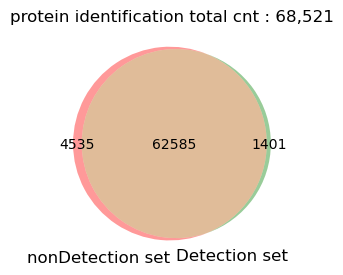

In [19]:
plt.figure(figsize=(3, 3))
v = venn2(subsets=[nid_proteins, id_proteins], set_labels=('nonDetection set', 'Detection set'))
plt.title('protein identification total cnt : {:,}'.format(len(nid_proteins.union(id_proteins))))
plt.show()

* Peptide idenfication count

In [20]:
id_precursors = {(k, v) for k, v in filter(lambda x: '+' not in x[0], df_id_target_removeDecoy[['Peptide', 'Charge']].values)}
nid_precursors = {(k, v) for k, v in filter(lambda x: '+' not in x[0], df_nid_target_removeDecoy[['Peptide', 'Charge']].values)}

print('nonDetection Peptide set : {:,}\n\
intersection cnt : {:,}\n\
Detection Peptide set : {:,}\n\
whole cnt : {:,}\n'.format(len(nid_precursors),
         len(nid_precursors.intersection(id_precursors)),
         len(id_precursors),
         len(nid_precursors.union(id_precursors))))

nonDetection Peptide set : 1,416,189
intersection cnt : 518
Detection Peptide set : 762,812
whole cnt : 2,178,483



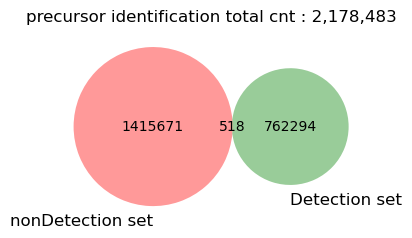

In [21]:
plt.figure(figsize=(4, 4))
v = venn2(subsets=[nid_precursors, id_precursors], set_labels=('nonDetection set', 'Detection set'))
plt.title('precursor identification total cnt : {:,}'.format(len(nid_precursors.union(id_precursors))))
plt.show()

nonDetection Peptide set : 1,416,189
intersection cnt : 1,074
Detection Peptide set : 455,968
whole cnt : 1,871,083



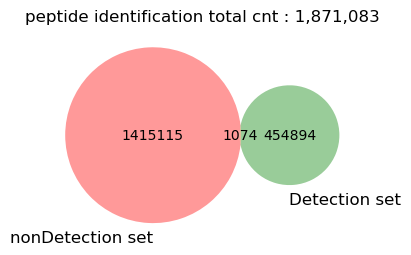

In [22]:
id_peptides = {k for k, v in filter(lambda x: '+' not in x[0], df_id_target_removeDecoy[['Peptide', 'Charge']].values)}
nid_peptides = {k for k, v in filter(lambda x: '+' not in x[0], df_nid_target_removeDecoy[['Peptide', 'Charge']].values)}

print('nonDetection Peptide set : {:,}\n\
intersection cnt : {:,}\n\
Detection Peptide set : {:,}\n\
whole cnt : {:,}\n'.format(len(nid_peptides),
         len(nid_peptides.intersection(id_peptides)),
         len(id_peptides),
         len(nid_peptides.union(id_peptides))))

plt.figure(figsize=(4, 4))
v = venn2(subsets=[nid_peptides, id_peptides], set_labels=('nonDetection set', 'Detection set'))
plt.title('peptide identification total cnt : {:,}'.format(len(nid_peptides.union(id_peptides))))
plt.show()

* MSGFscore violin plot

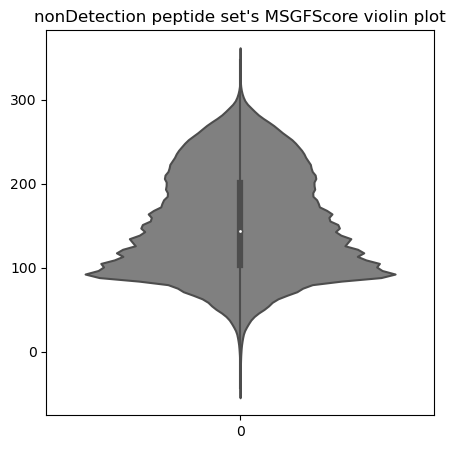

In [23]:
plt.figure(figsize=(5,5))
sns.violinplot(data=df_nid_target_removeDecoy.MSGFScore.values, color='gray')
plt.title('nonDetection peptide set\'s MSGFScore violin plot')
plt.show()

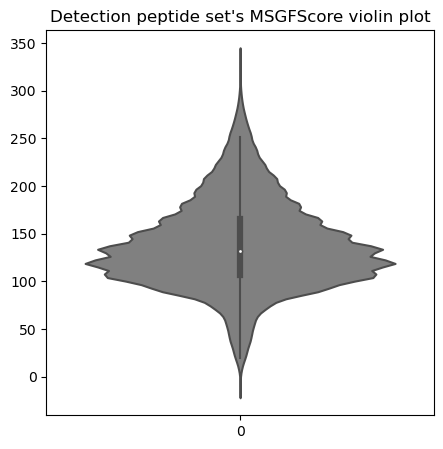

In [24]:
plt.figure(figsize=(5,5))
sns.violinplot(data=df_id_target_removeDecoy.MSGFScore.values, color='gray')
plt.title('Detection peptide set\'s MSGFScore violin plot')
plt.show()

In [25]:
df_nonid = pd.DataFrame([[_, 'nonID', 'score'] for _ in df_nid_target_removeDecoy.MSGFScore.values],
                        columns=['MSGFScore', 'label', 'score'])
df_id = pd.DataFrame([[_, 'ID', 'score'] for _ in df_id_target_removeDecoy.MSGFScore.values],
                     columns=['MSGFScore', 'label', 'score'])

df_MSGFScore = pd.concat([df_nonid, df_id], axis=0).reset_index(drop=True)

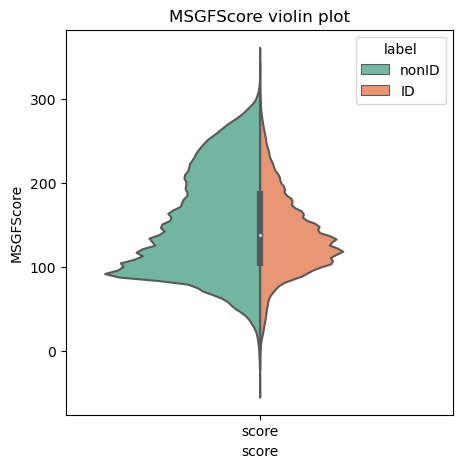

In [26]:
plt.figure(figsize=(5,5))
sns.violinplot(x='score', y="MSGFScore", hue="label",
                    data=df_MSGFScore, 
                    palette="Set2",
                    split=True,
                    scale="count"
                   )
plt.title('MSGFScore violin plot')
plt.show()

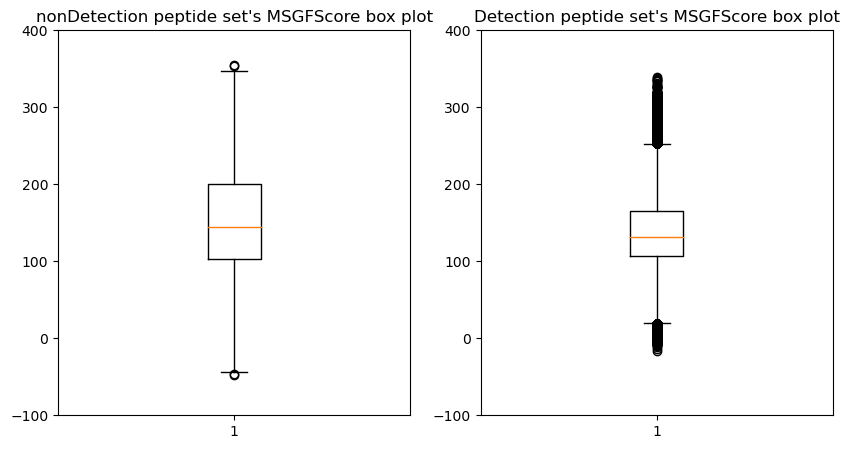

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10,5)
ax[0].boxplot(df_nid_target_removeDecoy.MSGFScore.values)
ax[1].boxplot(df_id_target_removeDecoy.MSGFScore.values)

ax[0].set_ylim(-100, 400)
ax[1].set_ylim(-100, 400)
ax[0].set_title('nonDetection peptide set\'s MSGFScore box plot')
ax[1].set_title('Detection peptide set\'s MSGFScore box plot')

plt.show()

# 3d plotting

In [28]:
df_id_target.head(2)

,#SpecFile,SpecID,ScanNum,Title,FragMethod,Precursor,IsotopeError,PrecursorError(ppm),Charge,Peptide,Protein,DeNovoScore,MSGFScore,SpecEValue,EValue,QValue,PepQValue,TD_label
0,massIVE-KB_predMS2_frac08.mgf,index=37341,-1,"483195 File:""massIVE-KB_predMS2_frac483195.mgf...",HCD,1246.1948,0,0.000000,3,LEITNCFPFPQHTEDDADFDEVQYQMEMMR,"sp|O15372|EIF3H_HUMAN(pre=R,post=S);tr|E5RGU4|...",226,226,5.448110e-41,1.507434e-33,0.0,0.0,T
1,massIVE-KB_predMS2_frac02.mgf,index=51968,-1,"115662 File:""massIVE-KB_predMS2_frac115662.mgf...",HCD,1247.8499,0,-0.097825,3,DNEVDFQEYCVFLSCIAMMCNEFFEGFPDK,"sp|P26447|S10A4_HUMAN(pre=R,post=Q)",210,209,8.602959e-41,2.380347e-33,0.0,0.0,T


In [29]:
df_id_2d = pd.DataFrame([[len(p), m, 'ID', 'score'] for p, m in df_id_target[['Peptide', 'MSGFScore']].values],
                        columns=['PeptideLength', 'MSGFScore', 'Label', 'score'])
df_nonid_2d = pd.DataFrame([[len(p), m, 'nonID', 'score'] for p, m in df_nid_target[['Peptide', 'MSGFScore']].values],
                        columns=['PeptideLength', 'MSGFScore', 'Label', 'score'])

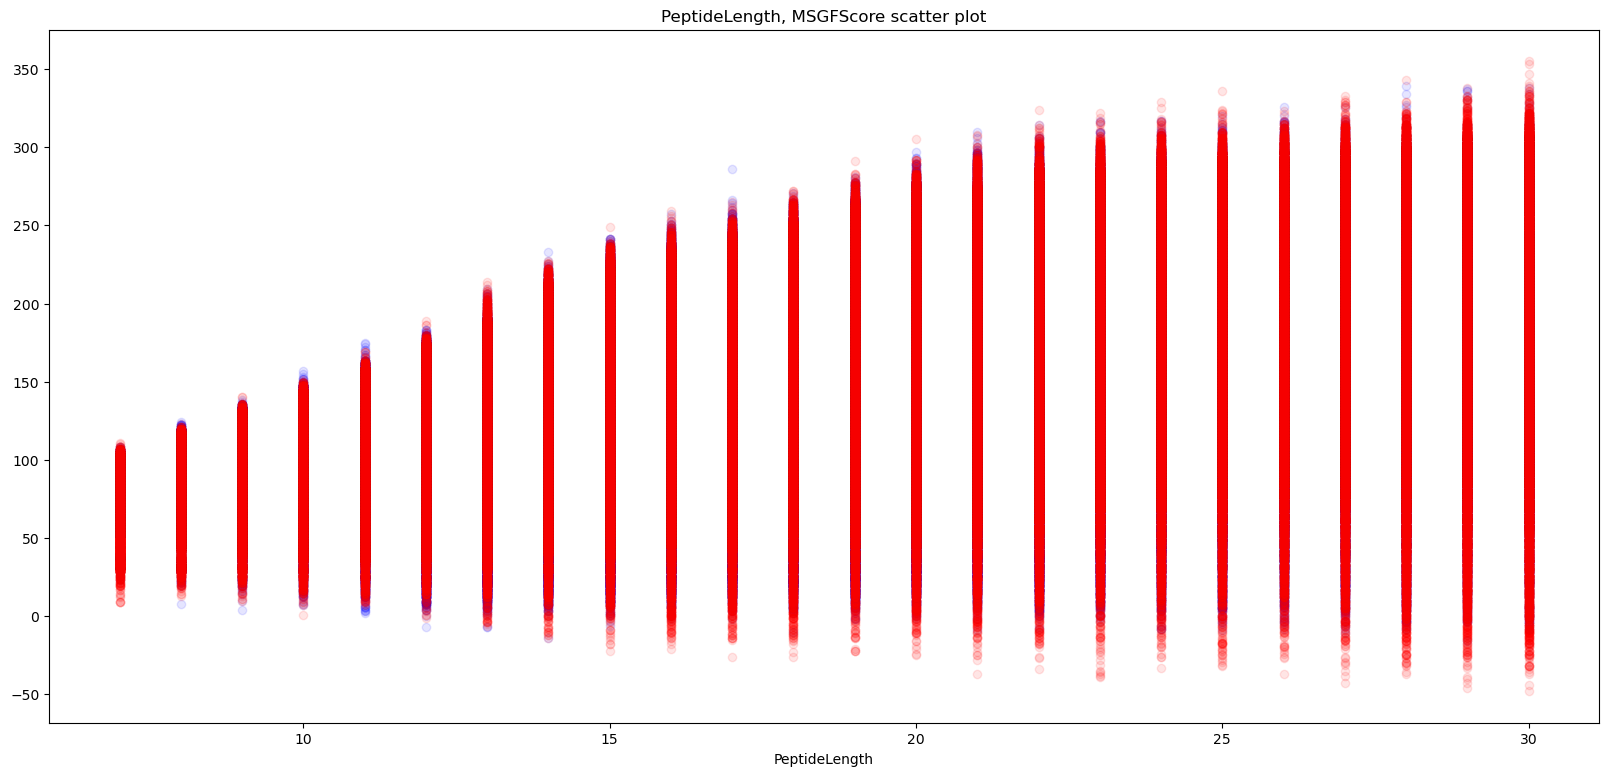

In [30]:
plt.figure(figsize=(20,9))

p = df_id_2d.sort_values('PeptideLength').PeptideLength.values
m = df_id_2d.sort_values('PeptideLength').MSGFScore.values
plt.scatter(p, m, alpha = 0.1, color='blue', label='ID')
p = df_nonid_2d.sort_values('PeptideLength').PeptideLength.values
m = df_nonid_2d.sort_values('PeptideLength').MSGFScore.values
plt.scatter(p, m, alpha = 0.1, color='red', label='nonID')

plt.title('PeptideLength, MSGFScore scatter plot')
plt.xlabel('PeptideLength')
plt.show()

In [31]:
df_nonid_2d.tail(2)

,PeptideLength,MSGFScore,Label,score
1422274,7,14,nonID,score
1422275,7,9,nonID,score


In [32]:
print('id min max : ', min(df_id_2d.MSGFScore.values), max(df_id_2d.MSGFScore.values), 
      '\nnid min max : ', min(df_nonid_2d.MSGFScore.values), max(df_nonid_2d.MSGFScore.values))

id min max :  -16 339 
nid min max :  -48 355


In [33]:
# lenscore2freq = {(p, m):0 for p in range(7, 31) for m in range(-48, 356)}
lenscore2freq = dict()
for p, m in df_id_2d[['PeptideLength', 'MSGFScore']].values:
    if (p, m) not in lenscore2freq:
        lenscore2freq[(p, m)] = 0
    lenscore2freq[(p, m)] += 1
df_id_3d = pd.DataFrame([[p, m, f, 'ID'] for (p, m), f in lenscore2freq.items()],
                              columns=['PeptideLength', 'MSGFScore', 'Frequency', 'Label'])

# lenscore2freq = {(p, m):0 for p in range(7, 31) for m in range(-48, 356)}
lenscore2freq = dict()
for p, m in df_nonid_2d[['PeptideLength', 'MSGFScore']].values:
    if (p, m) not in lenscore2freq:
        lenscore2freq[(p, m)] = 0
    lenscore2freq[(p, m)] += 1
df_nonid_3d = pd.DataFrame([[p, m, f, 'nonID'] for (p, m), f in lenscore2freq.items()],
                              columns=['PeptideLength', 'MSGFScore', 'Frequency', 'Label'])

In [105]:
%matplotlib notebook

<IPython.core.display.Javascript object>


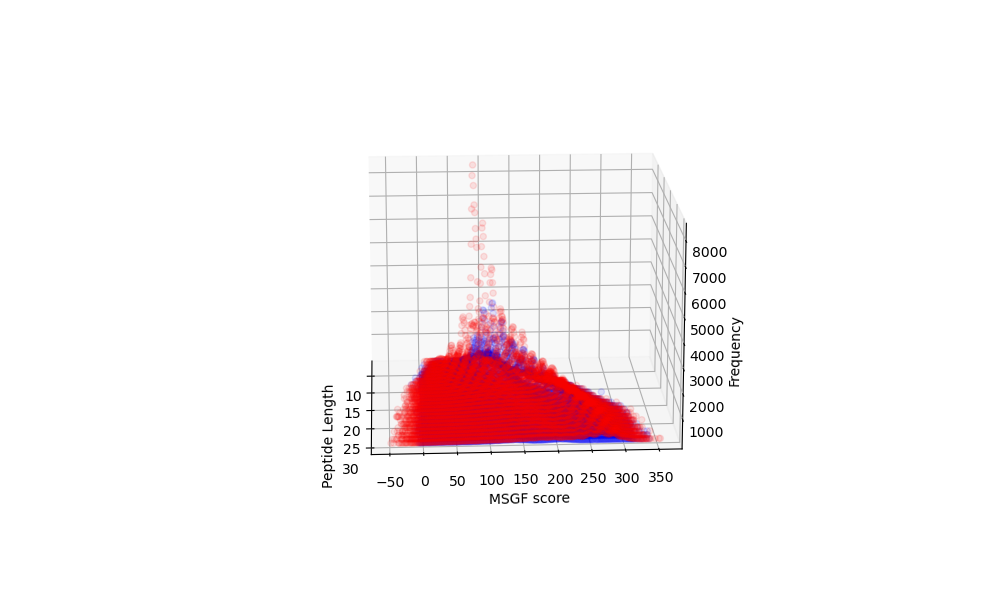

In [106]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

x = df_nonid_3d.PeptideLength.values
y = df_nonid_3d.MSGFScore.values
z = df_nonid_3d.Frequency.values
ax.scatter(x, y, z, alpha = 0.1, color='red')
x2 = df_id_3d.PeptideLength.values
y2 = df_id_3d.MSGFScore.values
z2 = df_id_3d.Frequency.values
ax.scatter(x2, y2, z2, alpha = 0.1, color='blue')

ax.set_zlim(1,8500)
ax.set_xlabel('Peptide Length')
ax.set_ylabel('MSGF score')
ax.set_zlabel('Frequency')
plt.show()

In [128]:
%matplotlib inline

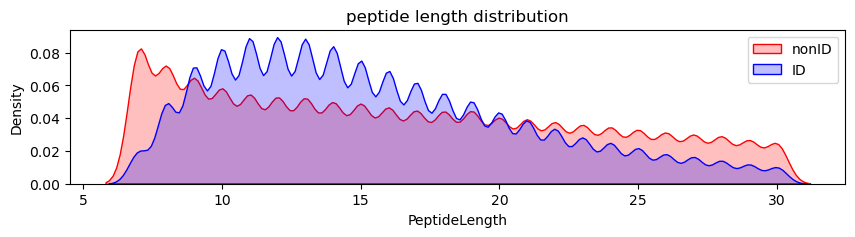

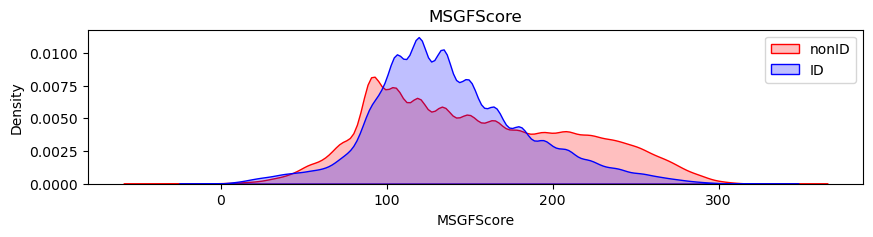

In [34]:
plt.figure(figsize=(10,2))
sns.kdeplot(df_nonid_2d.PeptideLength, shade=True, color='red')

sns.kdeplot(df_id_2d.PeptideLength, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('peptide length distribution')
plt.show()

plt.figure(figsize=(10,2))
sns.kdeplot(df_nonid_2d.MSGFScore, shade=True, color='red')

sns.kdeplot(df_id_2d.MSGFScore, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('MSGFScore')
plt.show()

# nofdr

In [35]:
df_id_result['TD'] = df_id_result.Protein.apply(isDecoy)
df_nid_result['TD'] = df_nid_result.Protein.apply(isDecoy)

df_id_T = df_id_result.loc[df_id_result.TD=='T'].reset_index(drop=True)
df_nid_T = df_nid_result.loc[df_nid_result.TD=='T'].reset_index(drop=True)

In [36]:
print(max(df_id_T.EValue.values), 
      min(df_id_T.EValue.values),  # maaIVE-KB
      max(df_nid_T.EValue.values), 
      min(df_nid_T.EValue.values))  # uniprot

127.47247 1.5074339925461614e-33 205.59102 1.442904175876456e-35


In [37]:
df_id_2d_T = pd.DataFrame([[len(p), m, se, e, 'ID', 'score'] 
                               for p, m, se, e in df_id_T[['Peptide', 'MSGFScore', 'SpecEValue', 'EValue']].values],
                        columns=['PeptideLength', 'MSGFScore', 'SpecEValue', 'EValue', 'Label', 'score'])
df_nonid_2d_T = pd.DataFrame([[len(p), m, se, e, 'nonID', 'score'] 
                               for p, m, se, e in df_nid_T[['Peptide', 'MSGFScore', 'SpecEValue', 'EValue']].values],
                        columns=['PeptideLength', 'MSGFScore', 'SpecEValue', 'EValue', 'Label', 'score'])

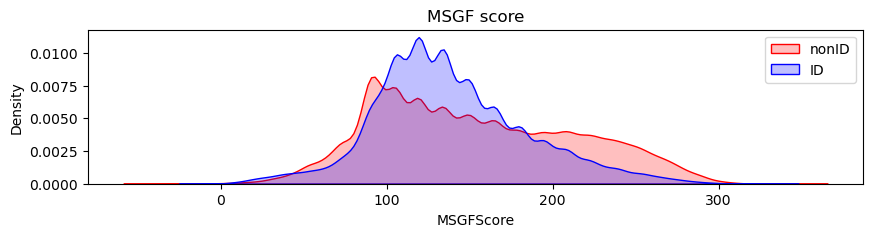

In [38]:
plt.figure(figsize=(10,2))
sns.kdeplot(df_nonid_2d_T.MSGFScore, shade=True, color='red')

sns.kdeplot(df_id_2d_T.MSGFScore, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('MSGF score')
plt.show()

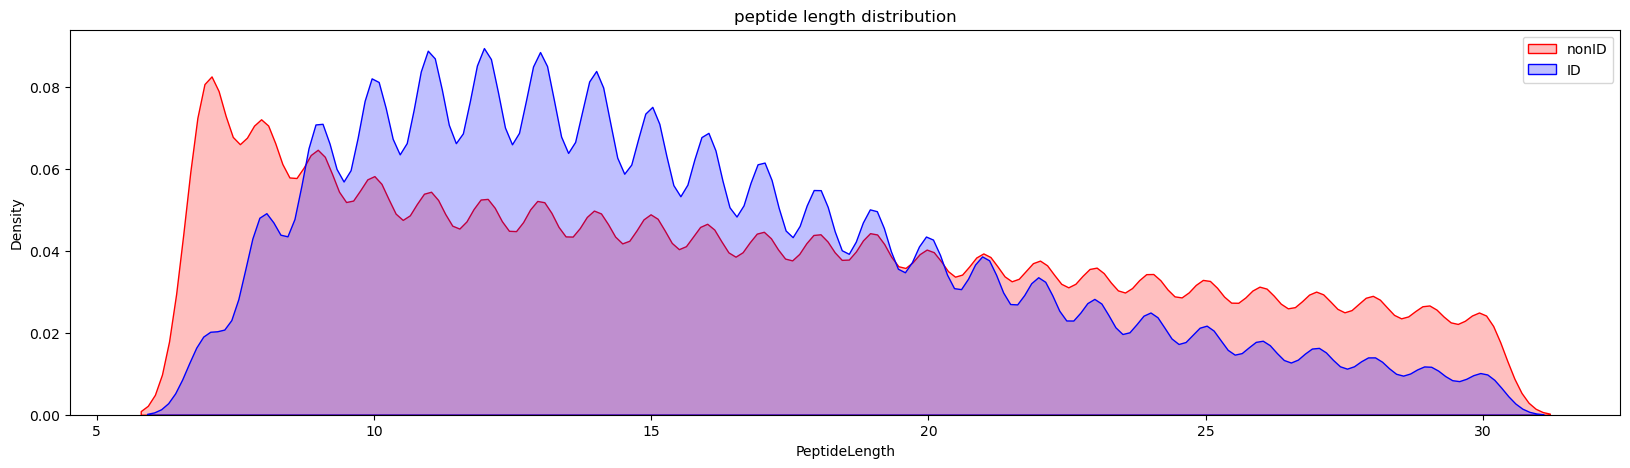

In [39]:
plt.figure(figsize=(20,5))
sns.kdeplot(df_nonid_2d_T.PeptideLength, shade=True, color='red')

sns.kdeplot(df_id_2d_T.PeptideLength, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('peptide length distribution')
plt.show()

In [40]:
df_nonid_2d_T['SpecEValue_log'] = df_nonid_2d_T.SpecEValue.apply(lambda x: -math.log(x))
df_id_2d_T['SpecEValue_log'] = df_id_2d_T.SpecEValue.apply(lambda x: -math.log(x))

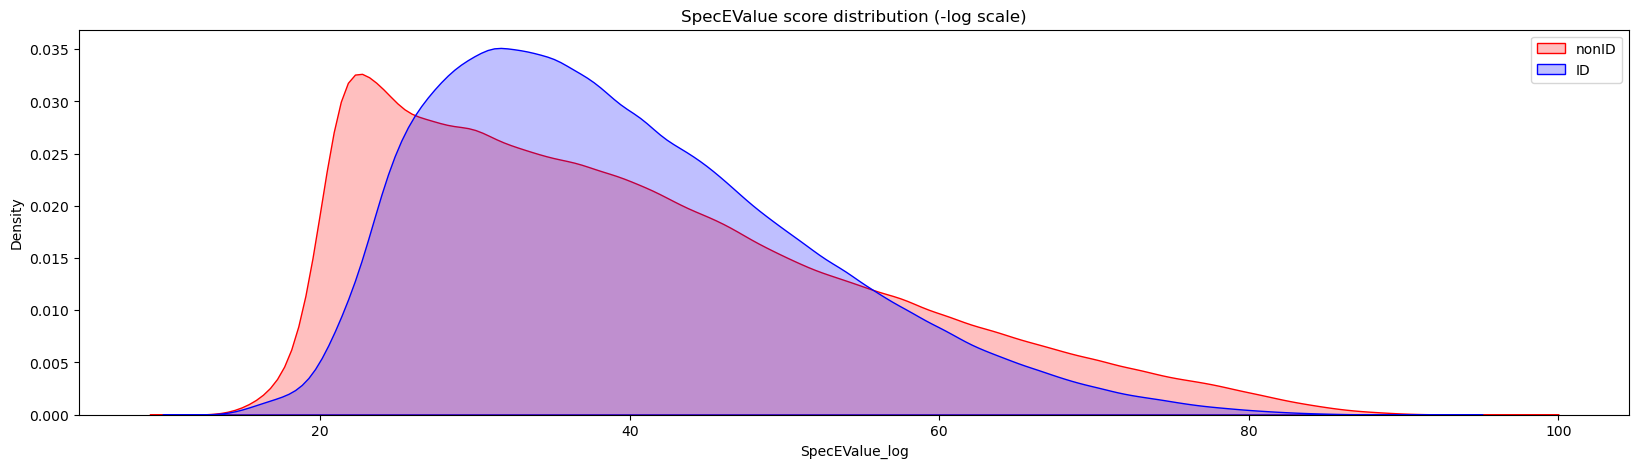

In [41]:
plt.figure(figsize=(20,5))
sns.kdeplot(df_nonid_2d_T.SpecEValue_log, shade=True, color='red')

sns.kdeplot(df_id_2d_T.SpecEValue_log, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('SpecEValue score distribution (-log scale)')
plt.show()

In [42]:
df_nonid_2d_T['EValue_log'] = df_nonid_2d_T.EValue.apply(lambda x: -math.log(x))
df_id_2d_T['EValue_log'] = df_id_2d_T.EValue.apply(lambda x: -math.log(x))

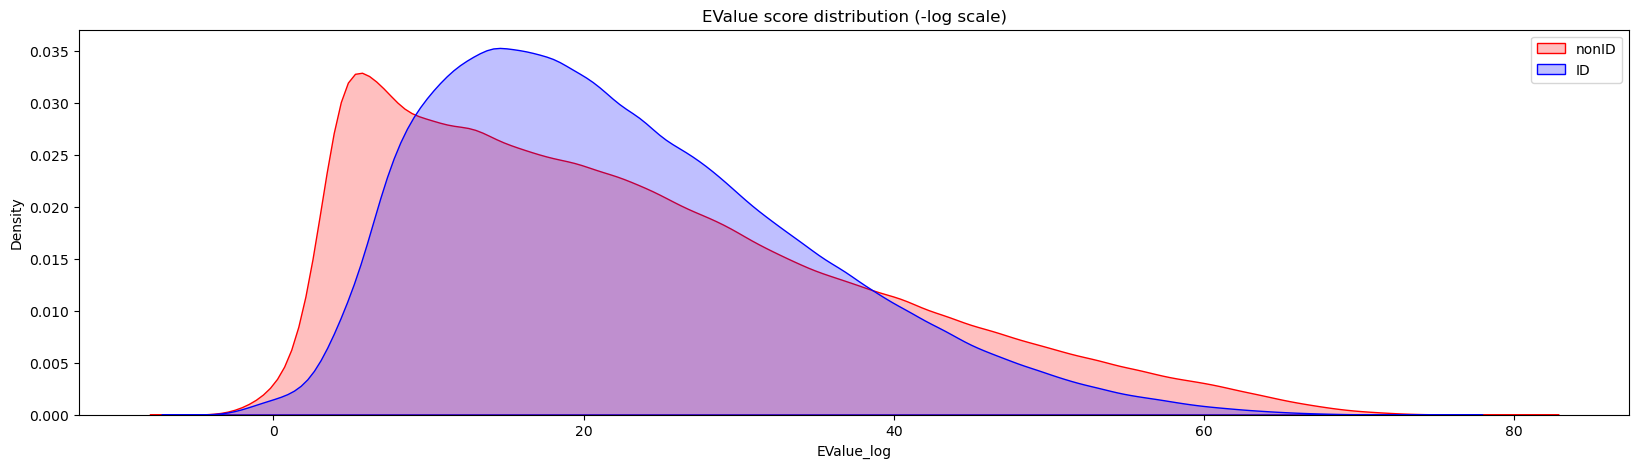

In [43]:
plt.figure(figsize=(20,5))
sns.kdeplot(df_nonid_2d_T.EValue_log, shade=True, color='red')

sns.kdeplot(df_id_2d_T.EValue_log, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('EValue score distribution (-log scale)')
plt.show()

In [44]:
print('id min max : ', min(df_id_2d_T.MSGFScore.values), max(df_id_2d_T.MSGFScore.values), 
      '\nnid min max : ', min(df_nonid_2d_T.MSGFScore.values), max(df_nonid_2d_T.MSGFScore.values))

id min max :  -16 339 
nid min max :  -48 355


In [45]:
# lenscore2freq = {(p, m):0 for p in range(7, 31) for m in range(-48, 356)}
lenscore2freq = dict()
for p, m in df_id_2d_T[['PeptideLength', 'MSGFScore']].values:
    if (p, m) not in lenscore2freq:
        lenscore2freq[(p, m)] = 0
    lenscore2freq[(p, m)] += 1
df_id_3d_T_MSGF = pd.DataFrame([[p, m, f, 'ID'] for (p, m), f in lenscore2freq.items()],
                              columns=['PeptideLength', 'MSGFScore', 'Frequency', 'Label'])

# lenscore2freq = {(p, m):0 for p in range(7, 31) for m in range(-48, 356)}
lenscore2freq = dict()
for p, m in df_nonid_2d_T[['PeptideLength', 'MSGFScore']].values:
    if (p, m) not in lenscore2freq:
        lenscore2freq[(p, m)] = 0
    lenscore2freq[(p, m)] += 1
df_nonid_3d_T_MSGF = pd.DataFrame([[p, m, f, 'nonID'] for (p, m), f in lenscore2freq.items()],
                              columns=['PeptideLength', 'MSGFScore', 'Frequency', 'Label'])

In [132]:
%matplotlib notebook

<IPython.core.display.Javascript object>


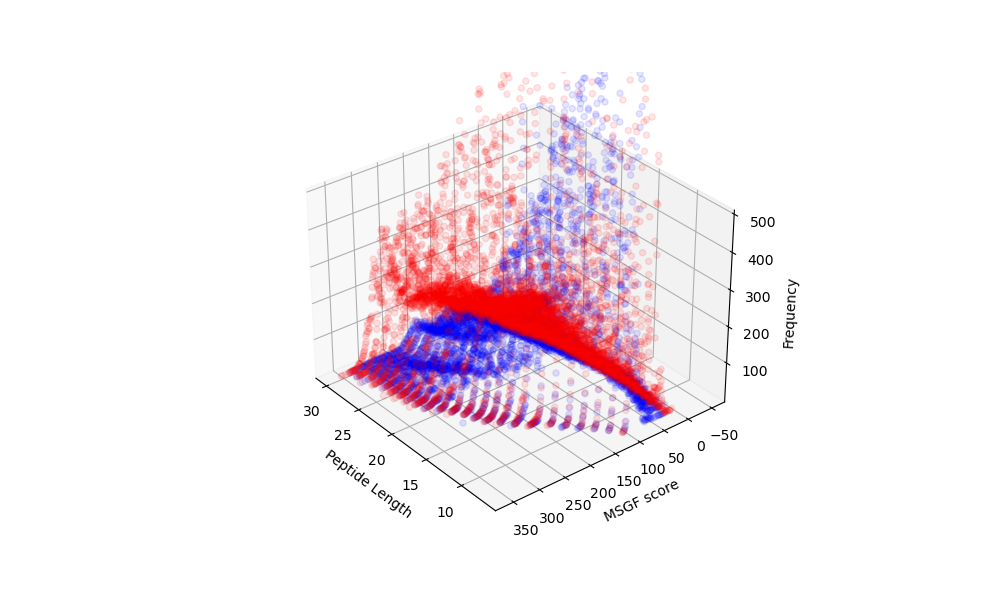

In [134]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

x = df_nonid_3d_T_MSGF.PeptideLength.values
y = df_nonid_3d_T_MSGF.MSGFScore.values
z = df_nonid_3d_T_MSGF.Frequency.values
ax.scatter(x, y, z, alpha = 0.1, color='red')
x2 = df_id_3d_T_MSGF.PeptideLength.values
y2 = df_id_3d_T_MSGF.MSGFScore.values
z2 = df_id_3d_T_MSGF.Frequency.values
ax.scatter(x2, y2, z2, alpha = 0.1, color='blue')

ax.set_zlim(1,500)
ax.set_xlabel('Peptide Length')
ax.set_ylabel('MSGF score')
ax.set_zlabel('Frequency')
plt.show()

In [46]:
df_id_2d_T['SpecEValue_logint'] = df_id_2d_T.SpecEValue_log.apply(lambda x: int(x))
df_nonid_2d_T['SpecEValue_logint'] = df_nonid_2d_T.SpecEValue_log.apply(lambda x: int(x))

In [47]:
# lenscore2freq = {(p, m):0 for p in range(7, 31) for m in range(-48, 356)}
lenscore2freq = dict()
for p, m in df_id_2d_T[['PeptideLength', 'SpecEValue_logint']].values:
    if (p, m) not in lenscore2freq:
        lenscore2freq[(p, m)] = 0
    lenscore2freq[(p, m)] += 1
df_id_3d_T_SpecEValue = pd.DataFrame([[p, m, f, 'ID'] for (p, m), f in lenscore2freq.items()],
                              columns=['PeptideLength', 'SpecEValue', 'Frequency', 'Label'])

# lenscore2freq = {(p, m):0 for p in range(7, 31) for m in range(-48, 356)}
lenscore2freq = dict()
for p, m in df_nonid_2d_T[['PeptideLength', 'SpecEValue_logint']].values:
    if (p, m) not in lenscore2freq:
        lenscore2freq[(p, m)] = 0
    lenscore2freq[(p, m)] += 1
df_nonid_3d_T_SpecEValue = pd.DataFrame([[p, m, f, 'nonID'] for (p, m), f in lenscore2freq.items()],
                              columns=['PeptideLength', 'SpecEValue', 'Frequency', 'Label'])

<IPython.core.display.Javascript object>


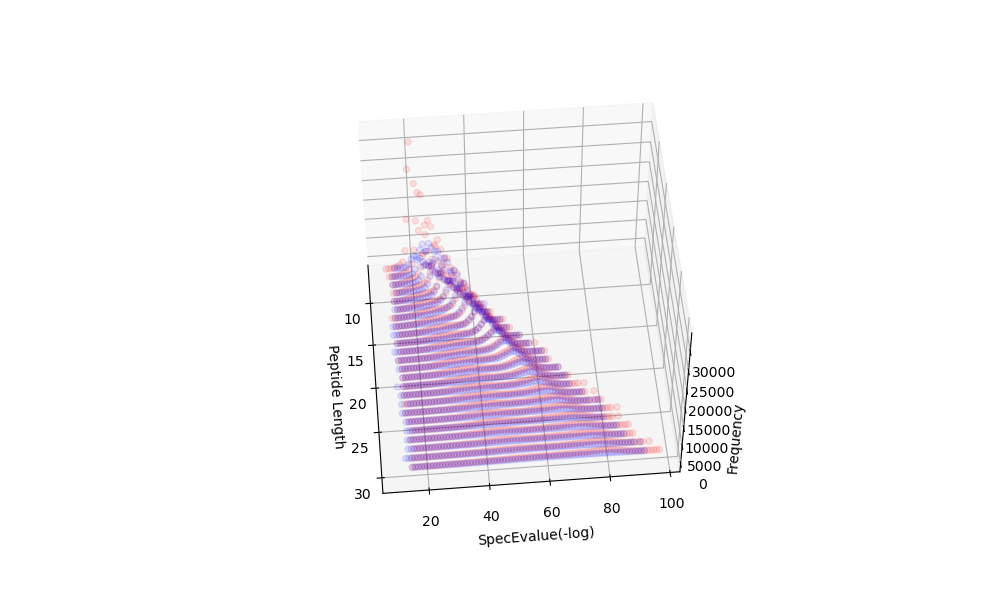

In [147]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

x = df_nonid_3d_T_SpecEValue.PeptideLength.values
y = df_nonid_3d_T_SpecEValue.SpecEValue.values
z = df_nonid_3d_T_SpecEValue.Frequency.values
ax.scatter(x, y, z, alpha = 0.1, color='red')
x2 = df_id_3d_T_SpecEValue.PeptideLength.values
y2 = df_id_3d_T_SpecEValue.SpecEValue.values
z2 = df_id_3d_T_SpecEValue.Frequency.values
ax.scatter(x2, y2, z2, alpha = 0.1, color='blue')

# ax.set_zlim(1,500)
ax.set_xlabel('Peptide Length')
ax.set_ylabel('SpecEvalue(-log)')
ax.set_zlabel('Frequency')
plt.show()

In [48]:
df_id_2d_T['EValue_logint'] = df_id_2d_T.EValue_log.apply(lambda x: int(x))
df_nonid_2d_T['EValue_logint'] = df_nonid_2d_T.EValue_log.apply(lambda x: int(x))

In [49]:
# lenscore2freq = {(p, m):0 for p in range(7, 31) for m in range(-48, 356)}
lenscore2freq = dict()
for p, m in df_id_2d_T[['PeptideLength', 'EValue_logint']].values:
    if (p, m) not in lenscore2freq:
        lenscore2freq[(p, m)] = 0
    lenscore2freq[(p, m)] += 1
df_id_3d_T_EValue = pd.DataFrame([[p, m, f, 'ID'] for (p, m), f in lenscore2freq.items()],
                              columns=['PeptideLength', 'EValue', 'Frequency', 'Label'])

# lenscore2freq = {(p, m):0 for p in range(7, 31) for m in range(-48, 356)}
lenscore2freq = dict()
for p, m in df_nonid_2d_T[['PeptideLength', 'EValue_logint']].values:
    if (p, m) not in lenscore2freq:
        lenscore2freq[(p, m)] = 0
    lenscore2freq[(p, m)] += 1
df_nonid_3d_T_EValue = pd.DataFrame([[p, m, f, 'nonID'] for (p, m), f in lenscore2freq.items()],
                              columns=['PeptideLength', 'EValue', 'Frequency', 'Label'])

<IPython.core.display.Javascript object>


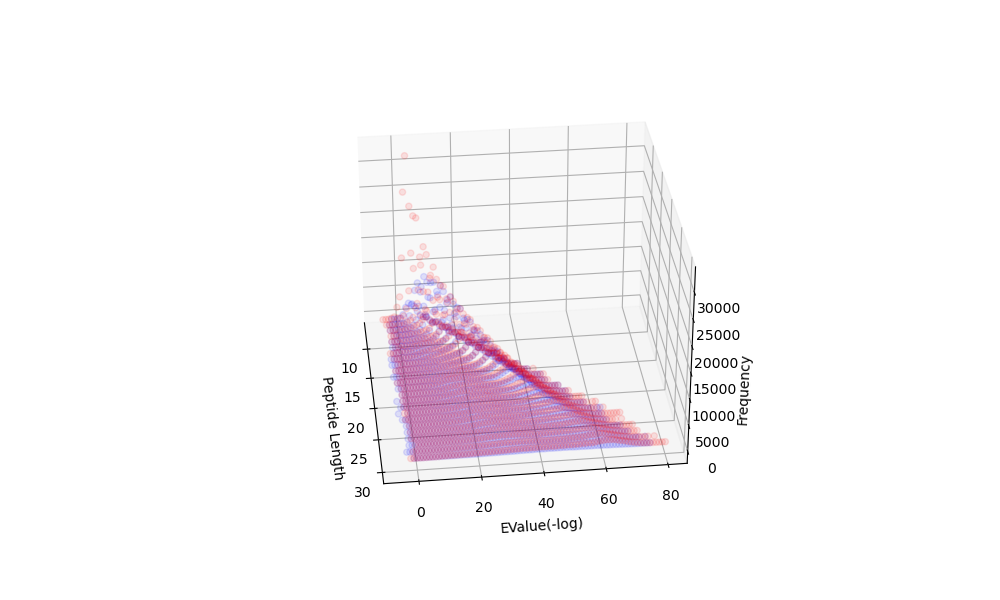

In [151]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

x = df_nonid_3d_T_EValue.PeptideLength.values
y = df_nonid_3d_T_EValue.EValue.values
z = df_nonid_3d_T_EValue.Frequency.values
ax.scatter(x, y, z, alpha = 0.1, color='red')
x2 = df_id_3d_T_EValue.PeptideLength.values
y2 = df_id_3d_T_EValue.EValue.values
z2 = df_id_3d_T_EValue.Frequency.values
ax.scatter(x2, y2, z2, alpha = 0.1, color='blue')

# ax.set_zlim(1,500)
ax.set_xlabel('Peptide Length')
ax.set_ylabel('EValue(-log)')
ax.set_zlabel('Frequency')
plt.show()

# specqual

In [50]:
import pickle

with open('../data/massIVE-KB/211025_stirp_pep2spec_pred.pickle', 'rb') as f:
    pep2spec_pred = pickle.load(f)
with open('../data/uniprot/211025_strip_npep2spec_pred.pickle', 'rb') as f:
    npep2spec_pred = pickle.load(f)

In [51]:
df_nid_T['KEY'] = df_nid_T.Title.apply(lambda x: x.split()[0]).values
df_id_T['KEY'] = df_id_T.Title.apply(lambda x: x.split()[0]).values

df_id_key = pd.DataFrame([[str(_+1), 
                           ';'.join(list(map(str, dic.keys()))),
                           ';'.join(list(map(str, dic.values()))),
                           p,
                           c,
                           True] for _, ((p, c), dic) in enumerate(pep2spec_pred.items())],
                         columns=['KEY', 'MZ', 'INT', 'PEP', 'CHA', 'DROP'])
df_nid_key = pd.DataFrame([[str(_+1), 
                           ';'.join(list(map(str, dic.keys()))),
                           ';'.join(list(map(str, dic.values()))),
                           p,
                           c,
                           True] for _, ((p, c), dic) in enumerate(npep2spec_pred.items())],
                         columns=['KEY', 'MZ', 'INT', 'PEP', 'CHA', 'DROP'])

df_nid_spec = df_nid_T.merge(df_nid_key, on='KEY', how='left').drop('DROP', axis=1)
df_id_spec = df_id_T.merge(df_id_key, on='KEY', how='left').drop('DROP', axis=1)

id_match_cnt = sum([1 for msgf_p, real_p in df_id_spec[['Peptide', 'PEP']].values if msgf_p == real_p])
nid_match_cnt = sum([1 for msgf_p, real_p in df_nid_spec[['Peptide', 'PEP']].values if msgf_p == real_p])

In [52]:
print(id_match_cnt, nid_match_cnt)
print(df_id_T.shape, df_id_spec.shape, df_nid_T.shape, df_nid_spec.shape)

761462 1414523
(762999, 19) (762999, 23) (1422276, 19) (1422276, 23)


In [53]:
df_id_spec.head(1)

,#SpecFile,SpecID,ScanNum,Title,FragMethod,Precursor,IsotopeError,PrecursorError(ppm),Charge,Peptide,...,SpecEValue,EValue,QValue,PepQValue,TD,KEY,MZ,INT,PEP,CHA
0,massIVE-KB_predMS2_frac01.mgf,index=48780,-1,"48781 File:""massIVE-KB_predMS2_frac48781.mgf"",...",HCD,1148.5422,0,0.0,3,ILGWGVENGTPYWLVANSWNTDWGDNGFFK,...,3.842356e-39,1.063139e-31,0.0,0.0,T,48781,147.112804167;294.18121816699994;441.249632166...,0.24706785;0.4907155;0.21187675;0.36394352;0.4...,ILGWGVENGTPYWLVANSWNTDWGDNGFFK,3


In [63]:
def spec2qual_thr(df, t):
    p2qualcnt = dict()
    p2qualratio = dict()
    for real_p, msgf_p, i, c in df[['PEP', 'Peptide', 'INT', 'CHA']].values:
        i = list(map(float, i.split(';')))
        length = (len(real_p)-1) * 6
        over = len(list(filter(lambda x: x>t, i)))
        p2qualcnt[(real_p, msgf_p, c)] = over
        p2qualratio[(real_p, msgf_p, c)] = over/length
    return p2qualcnt, p2qualratio

In [64]:
def qual_viz(bad_cnt, bad_ratio, good_cnt, good_ratio):
    df_nonid = pd.DataFrame([[_, 'bad_spec', 'cnt'] for _ in bad_cnt.values()], columns=['peakCnt', 'label', 'cnt'])
    df_id = pd.DataFrame([[_, 'good_spec', 'cnt'] for _ in good_cnt.values()], columns=['peakCnt', 'label', 'cnt'])
    df_peakcnt = pd.concat([df_nonid, df_id], axis=0).reset_index(drop=True)
    
    df_nonid = pd.DataFrame([[_, 'bad_spec', 'ratio'] for _ in bad_ratio.values()], columns=['peakratio', 'label', 'ratio'])
    df_id = pd.DataFrame([[_, 'good_spec', 'ratio'] for _ in good_ratio.values()], columns=['peakratio', 'label', 'ratio'])
    df_peakratio = pd.concat([df_nonid, df_id], axis=0).reset_index(drop=True)

    plt.figure(figsize=(5,5))
    sns.violinplot(x='cnt', y="peakCnt", hue="label",
                        data=df_peakcnt, 
                        palette="Set2",
                        split=True,
                        scale="count"
                       )
    plt.title('Prosit peak count violin plot')
    plt.show()
    plt.figure(figsize=(5,5))
    sns.violinplot(x='ratio', y="peakratio", hue="label",
                        data=df_peakratio, 
                        palette="Set2",
                        split=True,
                        scale="count"
                       )
    plt.title('Prosit peak ratio violin plot')
    plt.show()

In [56]:
%matplotlib inline

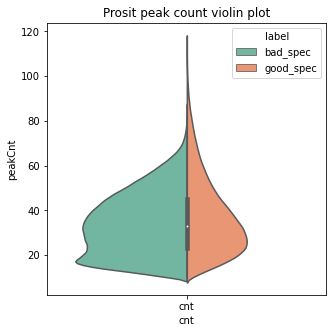

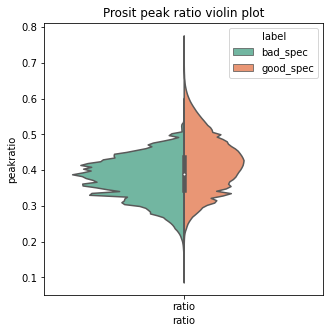

In [69]:
bc, br = spec2qual_thr(df_nid_spec, -1)
gc, gr = spec2qual_thr(df_id_spec, -1)
qual_viz(bc, br, gc, gr)

In [71]:
bc_3d = {k[0]:[v, len(k[0]), v / ((len(k[0])-1)*6)] for k, v in bc.items()}
gc_3d = {k[0]:[v, len(k[0]), v / ((len(k[0])-1)*6)] for k, v in gc.items()}

0.001


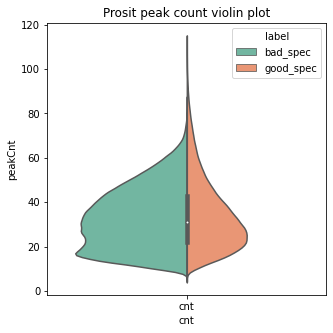

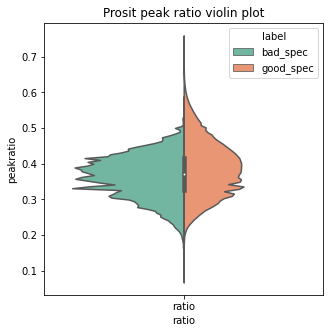

0.01


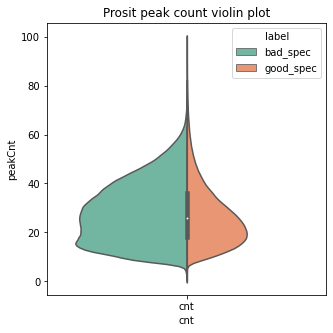

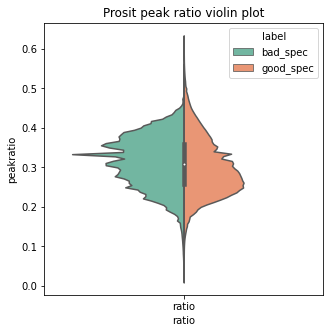

0.1


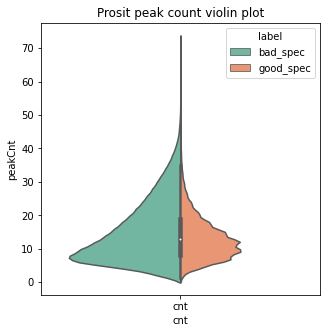

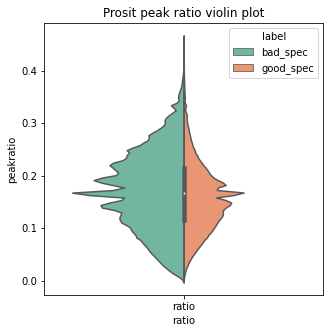

0.5


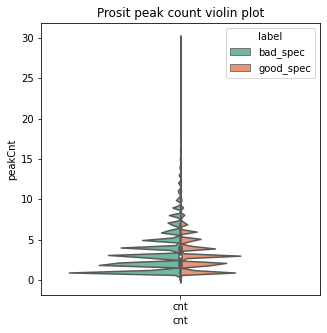

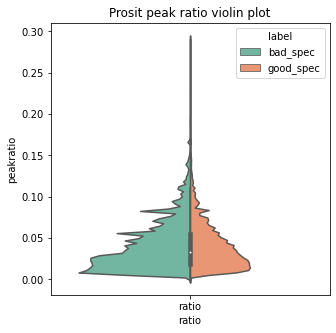

In [66]:
for thr in [0.001, 0.01, 0.1, 0.5]:
    print(thr)
    bc, br = spec2qual_thr(df_nid_spec, thr)
    gc, gr = spec2qual_thr(df_id_spec, thr)
    qual_viz(bc, br, gc, gr)

0.005


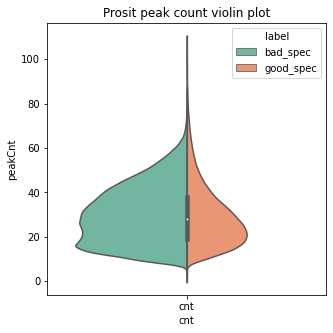

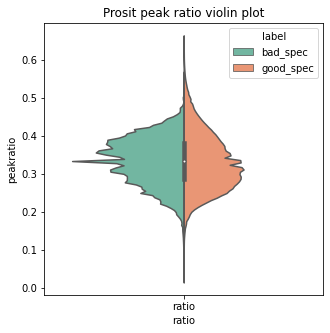

0.01


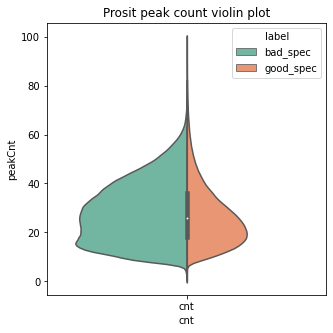

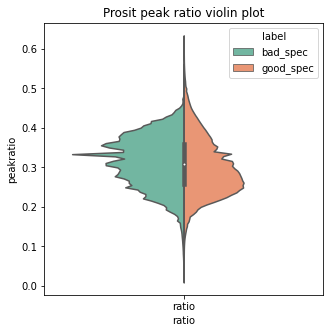

0.015


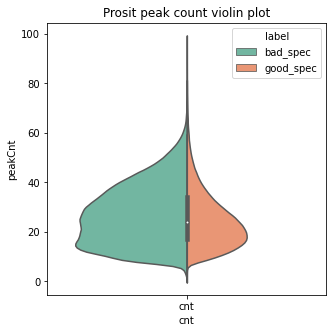

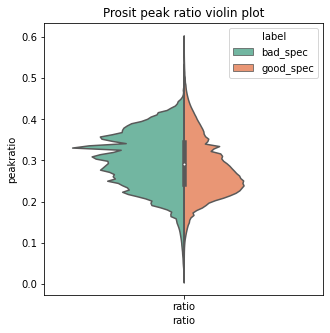

In [67]:
for thr in [0.005, 0.01, 0.015]:
    print(thr)
    bc, br = spec2qual_thr(df_nid_spec, thr)
    gc, gr = spec2qual_thr(df_id_spec, thr)
    qual_viz(bc, br, gc, gr)

0.2


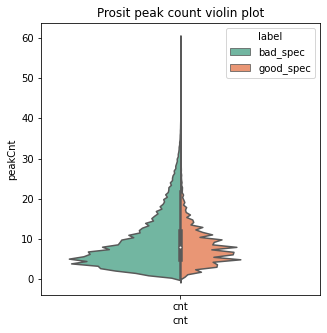

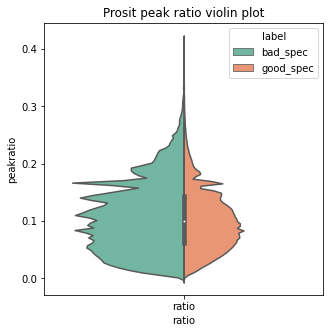

0.3


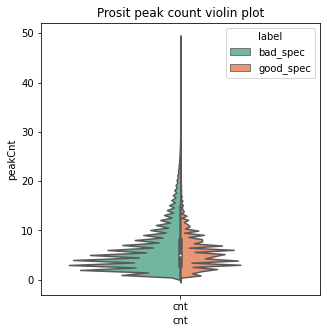

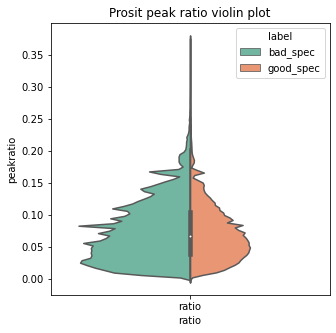

0.4


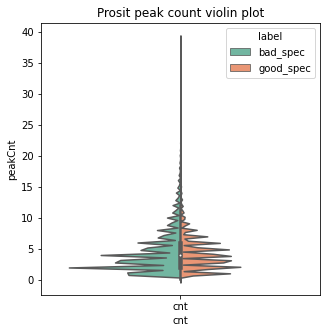

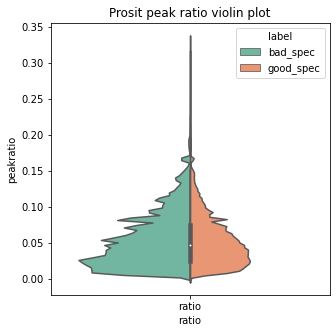

In [68]:
for thr in [0.2, 0.3, 0.4]:
    print(thr)
    bc, br = spec2qual_thr(df_nid_spec, thr)
    gc, gr = spec2qual_thr(df_id_spec, thr)
    qual_viz(bc, br, gc, gr)